In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# omd
import datetime
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '../../My-Code/timetools.py'>

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


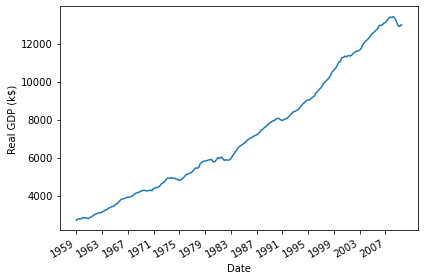

In [3]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH09_F01_peixeiro.png', dpi=300)

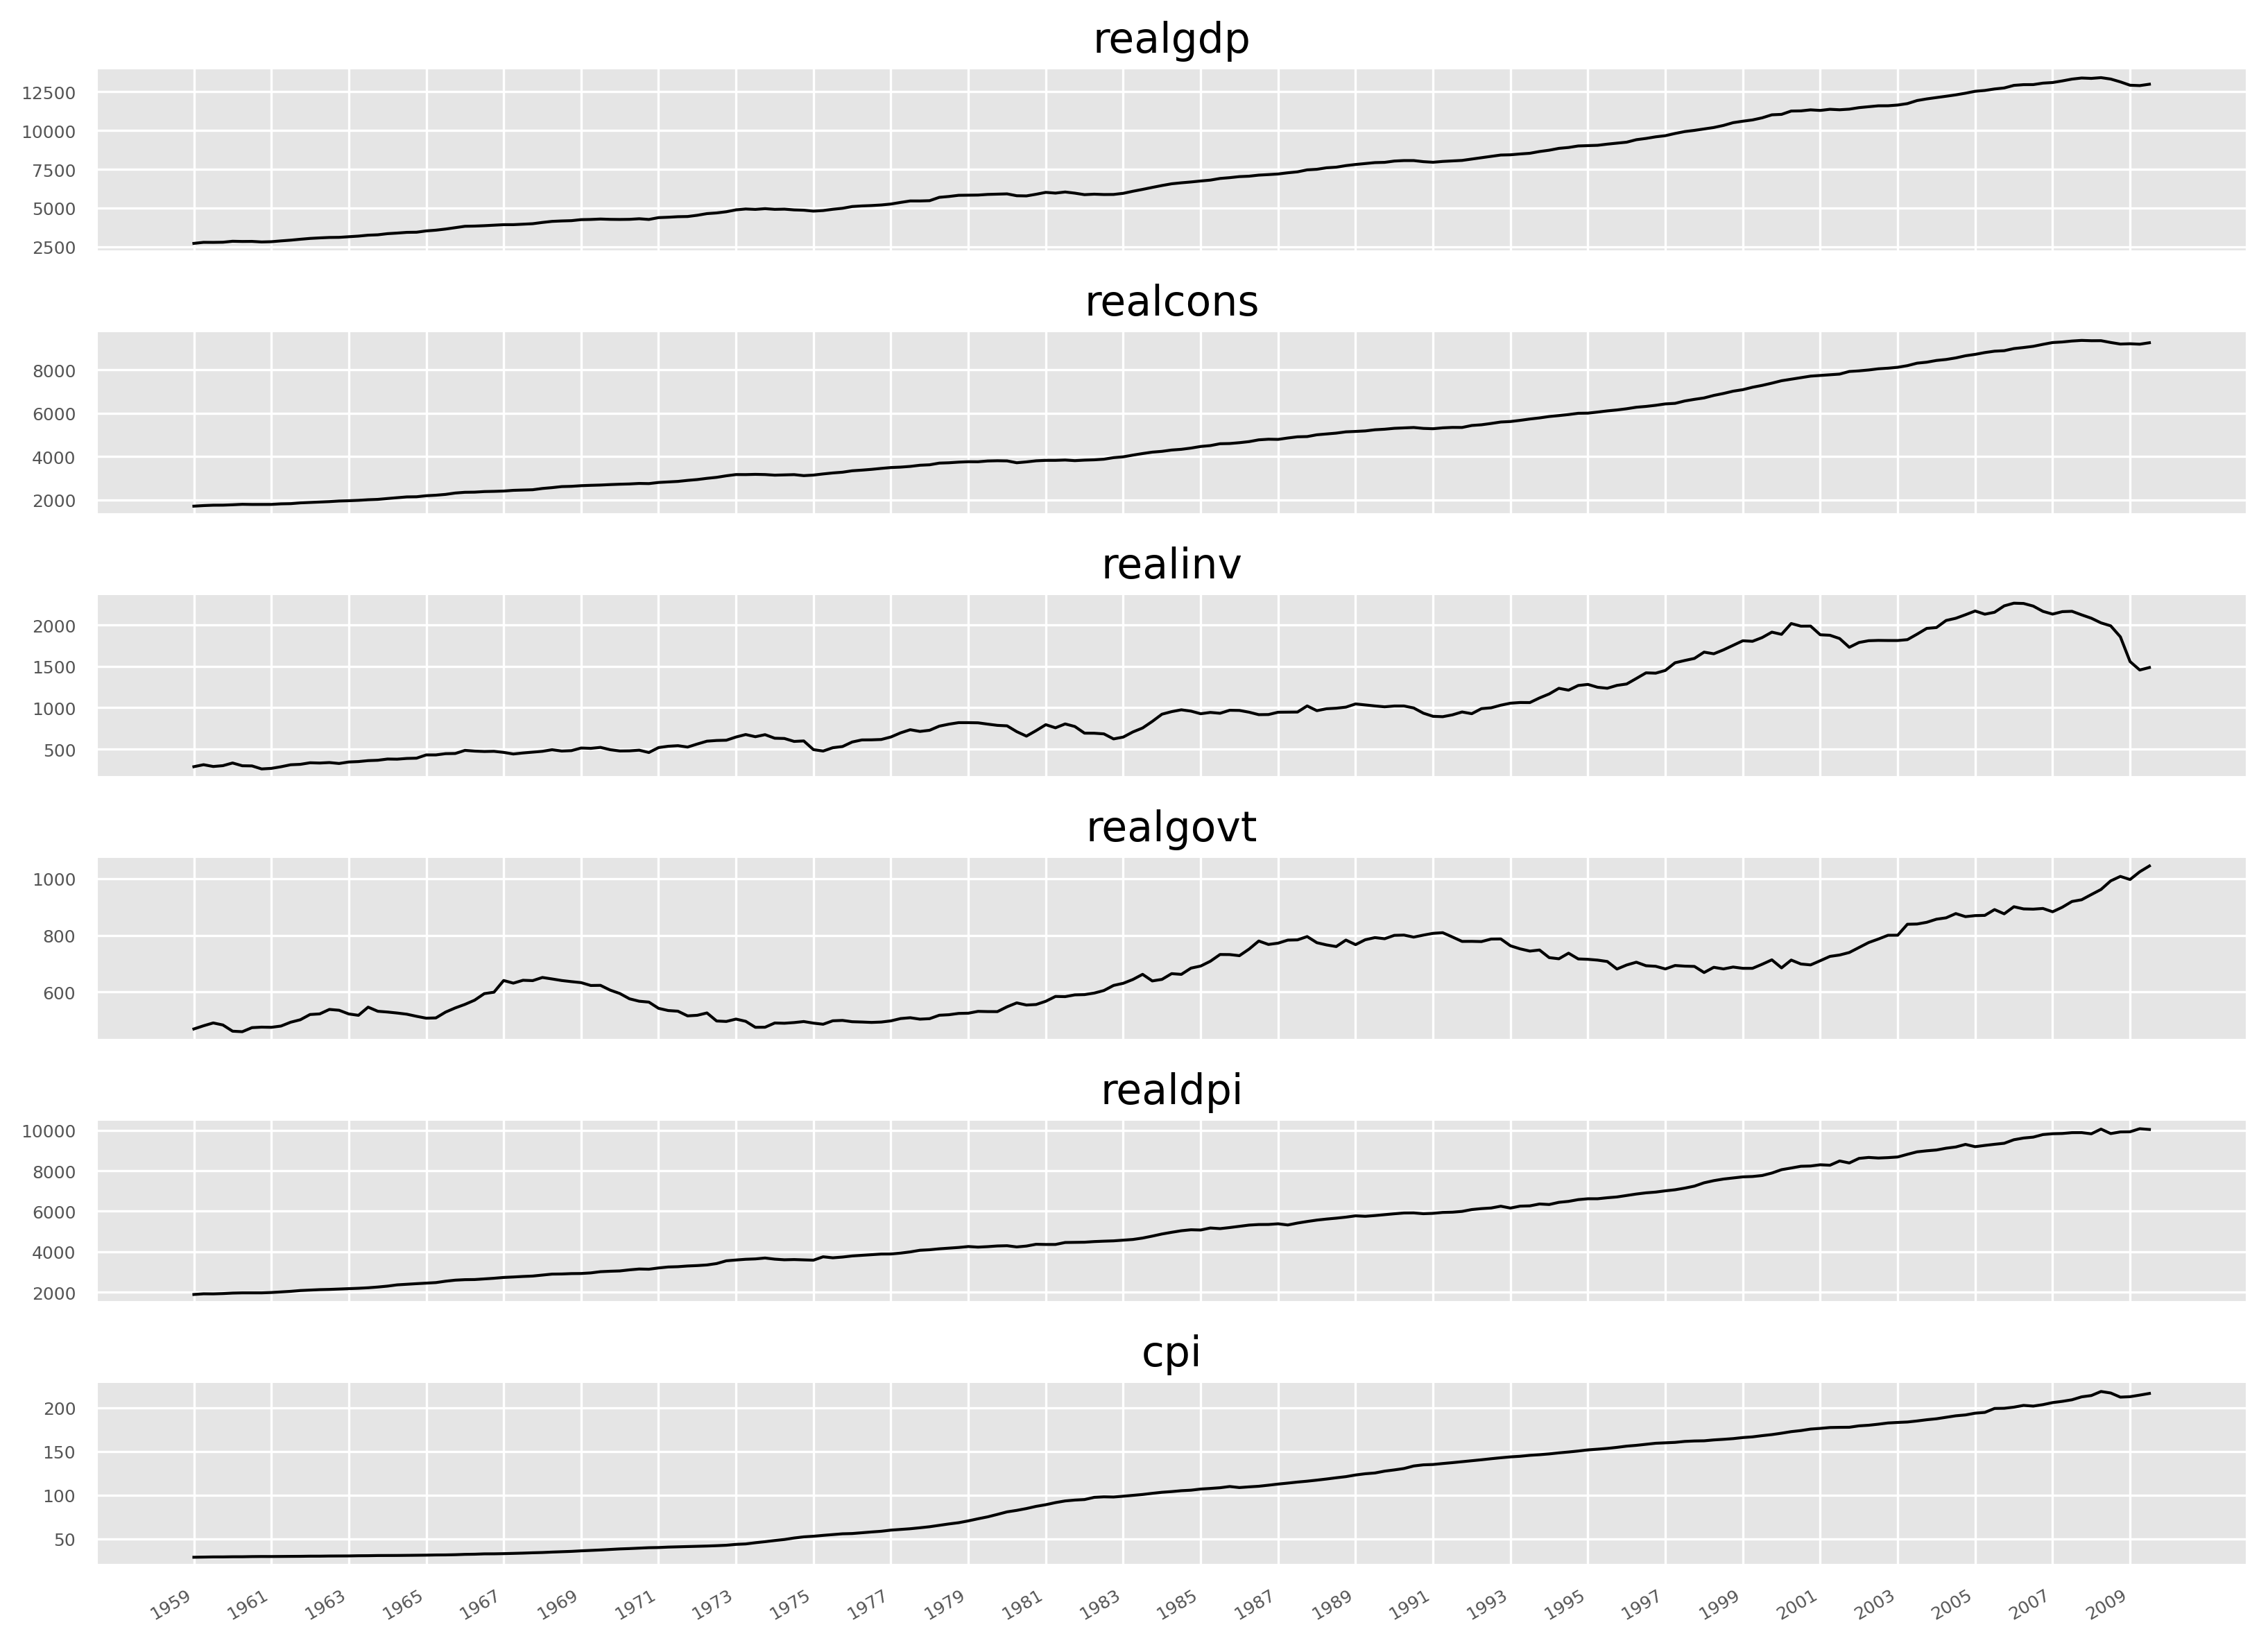

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=1, dpi=300, figsize=(11,8))


for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    plt.style.use('ggplot')
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/CH09_F02_peixeiro.png', dpi=300)

In [8]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [10]:
# ad_fuller_result = adfuller(target)

# print(f'ADF Statistic: {ad_fuller_result[0]}')
# print(f'p-value: {ad_fuller_result[1]}')

tt.adf(target)

Test Statistic                   1.750463
p-value                          0.998246
#Lags Used                      12.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64

The time series is not stationary.


In [12]:
target_diff = target.diff()

# ad_fuller_result = adfuller(target_diff[1:])

# print(f'ADF Statistic: {ad_fuller_result[0]}')
# print(f'p-value: {ad_fuller_result[1]}')

tt.adf(target_diff[1:])

Test Statistic                -6.305696e+00
p-value                        3.327882e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64

The time series is stationary.


In [13]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [16]:
# Here, we try values between 0 and 4 because it's quarterly data

p = range(0, 5, 1)
d = 1
q = range(0, 5, 1)
P = range(0, 5, 1)
D = 0
Q = range(0, 5, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [45]:
exog_train = pd.DataFrame(exog['realcons'], columns=['realcons'])
exog_train = tt.create_lagged_df(exog_train, lags=4)
exog_train = exog_train[:-4]
exog_train

,realcons,realcons_lag1,realcons_lag2,realcons_lag3,realcons_lag4
0,1707.4,1733.7,1751.8,1753.7,1770.5
1,1733.7,1751.8,1753.7,1770.5,1792.9
2,1751.8,1753.7,1770.5,1792.9,1785.8
3,1753.7,1770.5,1792.9,1785.8,1788.2
4,1770.5,1792.9,1785.8,1788.2,1787.7
...,...,...,...,...,...
194,9335.6,9363.6,9349.6,9351.0,9267.7
195,9363.6,9349.6,9351.0,9267.7,9195.3
196,9349.6,9351.0,9267.7,9195.3,9209.2
197,9351.0,9267.7,9195.3,9209.2,9189.0


In [49]:
# exog_train = pd.DataFrame(exog['realcons'], columns=['realcons'])
exog_train = pd.DataFrame(exog['realinv'], columns=['realinv'])     
exog_train = tt.create_lagged_df(exog_train, lags=4)

# remove NaNs
target_train = target[:-8]
exog_train = exog_train[:-8]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 0, 0)",1907.507063
1,"(1, 2, 0, 0)",1907.815710
2,"(3, 3, 0, 0)",1908.876462
3,"(2, 1, 1, 0)",1909.005464
4,"(2, 1, 0, 1)",1909.019624
...,...,...
425,"(0, 2, 0, 0)",2012.473722
426,"(0, 1, 0, 1)",2021.302860
427,"(0, 0, 0, 1)",2039.598352
428,"(0, 1, 0, 0)",2044.303858


## <font color='blue'>realinv</font> with no lag is the best regressor.  The coefficient for it is the largest while p < 0.05.

In [56]:
best_model = SARIMAX(target_train, exog_train.iloc[:,:], order=(2,1,1), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  195
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -944.754
Date:                Fri, 14 Jan 2022   AIC                           1907.507
Time:                        18:32:45   BIC                           1936.918
Sample:                             0   HQIC                          1919.416
                                - 195                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
realinv          1.0273      0.053     19.364      0.000       0.923       1.131
realinv_lag1     0.2419      0.062      3.925      0.000       0.121       0.363
realinv_lag2     0.1063      0.066      1.61

In [55]:
best_model = SARIMAX(target_train, exog_train.iloc[:,0], order=(2,1,1), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  195
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -956.580
Date:                Fri, 14 Jan 2022   AIC                           1923.160
Time:                        18:29:18   BIC                           1939.500
Sample:                             0   HQIC                          1929.777
                                - 195                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realinv        1.0698      0.054     19.820      0.000       0.964       1.176
ar.L1          0.8491      0.100      8.483      0.000       0.653       1.045
ar.L2          0.1471      0.098      1.503      0.1

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH09_F05_peixeiro.png', dpi=300)

In [ ]:
residuals = best_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

In [ ]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [ ]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

In [ ]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH09_F06_peixeiro.png', dpi=300)